In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from pathlib import Path
from collections import Counter

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import dill
import pandas as pd
import polars as pl
import numpy as np
from scipy.sparse import csr_matrix

import pytorch_lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from tasks.data.dataset.mappers import EntityEncoder
from tasks.jobs import Splitter

In [80]:
from otto_utils import *

In [4]:
df_train = pl.read_parquet(TRAIN_PROCESSED, use_pyarrow=True)
df_test = pl.read_parquet(TEST_PROCESSED, use_pyarrow=True)

In [4]:
# load
val_df_train = pl.read_parquet(VALIDATION_PATH / "train.parquet", use_pyarrow=True)
val_df_valid_input = pl.read_parquet(VALIDATION_PATH / "valid.parquet", use_pyarrow=True)
val_df_valid_targets = pl.read_parquet(VALIDATION_PATH / "test_labels.parquet", use_pyarrow=True)

In [5]:
val_df_train = (
    val_df_train
    .with_columns([
        pl.col("ts").cast(pl.Datetime(time_unit="ms", time_zone="Etc/GMT-2")).alias("dt")
    ])
    .with_columns([
        pl.col("dt").cast(pl.Date)
    ])
)

val_df_valid_input = (
    val_df_valid_input
    .with_columns([
        pl.col("ts").cast(pl.Datetime(time_unit="ms", time_zone="Etc/GMT-2")).alias("dt")
    ])
    .with_columns([
        pl.col("dt").cast(pl.Date)
    ])
)

In [6]:
s, _ = data_stats(
    pl.concat([
        val_df_train, val_df_valid_input
    ])
)

In [15]:
df = pl.concat([
    val_df_train.filter(pl.col("session").is_in(
        s.filter(pl.col("min_ts") >= datetime(2022, 8, 15))["session"]
    )),
    val_df_valid_input
])

# Only last week (aka test) carts and buys

In [77]:
val_df_train.filter(pl.col("session").is_in(
        s.filter(pl.col("min_ts") >= datetime(2022, 8, 15))["session"]
    ))["session"].n_unique()

2448907

In [16]:
sessions_buys =(
    df
    .groupby(["session", "type"])
    .agg([
        pl.count("aid")
    ])
    .pivot(index="session", columns="type", values="aid")
    .filter(
        pl.col("1").is_not_null() |
        pl.col("2").is_not_null()
    )
    .fill_null(0)
    .with_columns([
        (pl.col("0") + pl.col("1") + pl.col("2")).alias("len")
    ])
)

In [17]:
sessions_buys

session,2,0,1,len
i64,u32,u32,u32,u32
8838566,2,43,3,48
9002609,2,29,2,33
11721316,0,5,1,6
8743983,1,12,4,17
10343242,1,6,1,8
12292485,0,3,1,4
12770614,0,6,2,8
10250338,5,8,5,18
10966775,6,7,6,19


<AxesSubplot: ylabel='Density'>

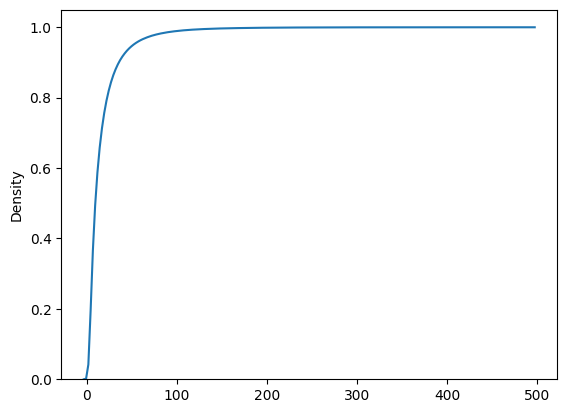

In [20]:
sns.kdeplot(sessions_buys["len"], cumulative=True)

In [12]:
val_df_train_dt_stats = (
    pl.concat([val_df_train.filter(pl.col("session").is_in(
        s.filter(pl.col("min_ts") >= datetime(2022, 8, 15))["session"]
    )),
    val_df_valid_input])
    .groupby("session")
    .agg([
        pl.count("aid"),
        pl.min("dt"),
        ((pl.max("ts") - pl.min("ts")) / 1000).alias("sess_len")
    ])
    .groupby("dt")
    .agg([pl.n_unique("session"), pl.mean("aid"), pl.mean("sess_len")])
)

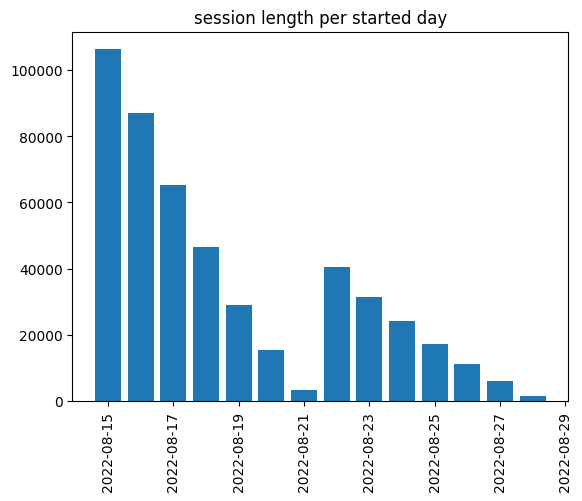

In [13]:
x = val_df_train_dt_stats["dt"].to_list()
y = val_df_train_dt_stats["sess_len"].to_list()

plt.bar(x, height=y)
plt.xticks(rotation=90)
plt.title("session length per started day")
plt.show()

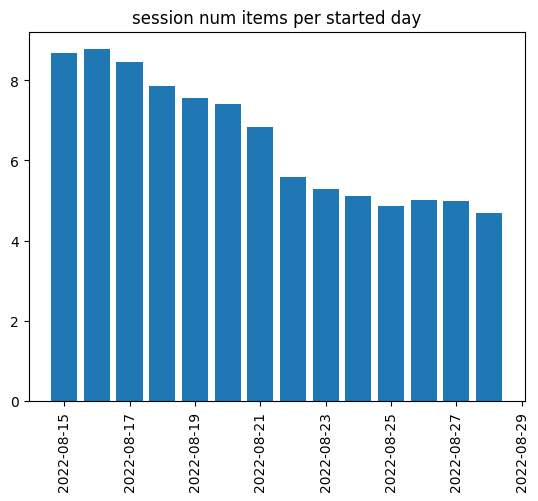

In [14]:
x = val_df_train_dt_stats["dt"].to_list()
y = val_df_train_dt_stats["aid"].to_list()

plt.bar(x, height=y)
plt.xticks(rotation=90)
plt.title("session num items per started day")
plt.show()

In [19]:
sessions_buys =(
#     pl.concat([val_df_train.filter(pl.col("session").is_in(
#         s.filter(pl.col("min_ts") >= datetime(2022, 8, 15))["session"]
#     )),
#                val_df_valid_input])
    val_df_valid_input
    .groupby(["session", "type"])
    .agg([
        pl.count("aid")
    ])
    .pivot(index="session", columns="type", values="aid")
    .filter(
        pl.col("1").is_not_null() |
        pl.col("2").is_not_null()
    )
    .fill_null(0)
    .with_columns([
        (pl.col("0") + pl.col("1") + pl.col("2")).alias("len")
    ])
)

In [21]:
def build_input_sequences(pldf_interactions):
    return (
        pldf_interactions
        .sort("ts")
        .groupby(["session", "uiid"])
        .agg([
            pl.list("miid").alias("miid_seq"),
            pl.list("ts").alias("ts_seq"),
            pl.list("type").alias("transaction_seq"),
#             pl.list("transaction_weight").alias("transaction_seq"),
        ])
    )

def build_target(
        df: pl.DataFrame, user_col: str, item_col: str, ts_col: str, filter: bool = True
    ) -> pl.DataFrame:
    if filter:
        df = df.filter(pl.col("is_transaction") == 1)
        
    return (
        df
        .sort(ts_col)
        .groupby(user_col)
        .agg([
            pl.list(item_col),
            pl.list(ts_col),
            # pl.list(weight_col),
        ])
    )

In [27]:
df_train_interactions_warm = (
    df
    .filter(pl.col("session").is_in(sessions_buys["session"]))
    .filter(pl.col("session").is_in(sessions_buys.filter(pl.col("len") >= 5)["session"]))
)

In [28]:
df_train_interactions_warm["session"].n_unique(), df_train_interactions_warm["aid"].n_unique()

(636178, 1000017)

In [31]:
session_encoder = EntityEncoder(ext_name="session", int_name="uiid")
aid_encoder = EntityEncoder(ext_name="aid", int_name="miid")
session_encoder.set_external_ids(df_train_interactions_warm["session"])
aid_encoder.set_external_ids(df_train_interactions_warm["aid"])

In [32]:
df_train_interactions_warm = (
    df_train_interactions_warm
    .join(session_encoder.mapping_df, on="session", how="left")  # all users
    .join(aid_encoder.mapping_df, on="aid", how="inner")  # only known models
)

In [34]:
val_df_valid_input["session"].n_unique(), val_df_valid_input["aid"].n_unique()

(1303355, 802015)

In [33]:
val_df_valid_input_remapped = (
    val_df_valid_input
    .join(session_encoder.mapping_df, on="session", how="left")  # all users
    .join(aid_encoder.mapping_df, on="aid", how="inner")  # only known models
)

In [35]:
val_df_valid_input_remapped["session"].n_unique(), val_df_valid_input_remapped["aid"].n_unique()

(1261433, 649940)

In [38]:
splitter = Splitter()
_, val_df_valid_40k = splitter.user_split(
    val_df_valid_input_remapped, user_col="session", test_size = 40_000
)

In [40]:
val_df_valid_40k

40000

In [39]:
# val_df_valid_100k = (
#     val_df_valid_100k
#     .join(session_encoder.mapping_df, on="session", how="left")  # all users
#     .join(aid_encoder.mapping_df, on="aid", how="inner")  # only known models
# )

In [68]:
# val_df_valid_full = (
#     val_df_valid_input
#     .join(session_encoder.mapping_df, on="session", how="left")  # all users
#     .join(aid_encoder.mapping_df, on="aid", how="inner")  # only known models
# )

In [ ]:
#             pldf_test_seq = (
#                 pldf_test_users
#                 .join(pldf_test_seq, on="user_id", how="left")
#             )
#             # print(pldf_test_seq)

            
#             pldf_test_seq = (
#                 pldf_test_seq
#                 .with_columns([
#                     # pl.col("uiid").fill_null(pl.lit(user_encoder.size())),
#                     pl.col("miid_seq").fill_null(pl.Series("", empty_seqs, dtype=pl.List(pl.Int64))),
#                     # pl.col("ts_seq").fill_null(pl.Series("", empty_seqs)),  # FIX IT!!!
#                     pl.col("transaction_seq").fill_null(pl.Series("", empty_seqs, dtype=pl.List(pl.Int64))),
#                 ])
#             )

In [49]:
df_val_sessions = val_df_valid_input.select(["session"]).unique()
empty_seqs = [[] for _ in range(df_val_sessions.shape[0])]
df_test_seq = (
    df_val_sessions
    .join(build_input_sequences(val_df_valid_input_remapped), on="session", how="left")
    .with_columns([
        pl.col("miid_seq").fill_null(pl.Series("", empty_seqs, dtype=pl.List(pl.Int64))),
#         pl.col("ts_seq").fill_null(pl.Series("", empty_seqs)),  # FIX IT!!!
        pl.col("transaction_seq").fill_null(pl.Series("", empty_seqs, dtype=pl.List(pl.Int64))),
    ])
    .sort("session")
)

In [51]:
df_test_seq

session,uiid,miid_seq,ts_seq,transaction_seq
i64,i64,list[i64],list[i64],list[i64]
11107743,null,"[670035, 393848, 670035]","[1661126400192, 1661126418250, 1661391126514]","[0, 0, 0]"
11107744,null,"[118630, 838930, ... 838930]","[1661126401190, 1661126439064, ... 1661126463911]","[0, 1, ... 0]"
11107745,null,"[415123, 906579, ... 360729]","[1661126402749, 1661126476951, ... 1661126813401]","[0, 0, ... 0]"
11107746,null,"[611491, 428483]","[1661126404790, 1661126527755]","[0, 0]"
11107747,468309,"[542341, 542341, ... 332602]","[1661126408858, 1661126509993, ... 1661464719813]","[0, 0, ... 0]"
11107748,null,[621991],[1661126410139],[0]
11107749,null,"[82749, 342521]","[1661126410217, 1661188513088]","[0, 0]"
11107750,null,"[20507, 392613]","[1661126412752, 1661384220709]","[0, 0]"
11107754,null,[775140],[1661126423457],[0]


In [42]:
df_train_seq = build_input_sequences(df_train_interactions_warm)
df_val_seq = build_input_sequences(val_df_valid_40k)

In [45]:
df_train_seq

session,uiid,miid_seq,ts_seq,transaction_seq
i64,i64,list[i64],list[i64],list[i64]
12084974,562036,"[194946, 194946, ... 908815]","[1661446950093, 1661447011750, ... 1661529035758]","[0, 1, ... 0]"
9865104,244047,"[16484, 16484, ... 764086]","[1660808945642, 1660809064866, ... 1660813512293]","[0, 1, ... 0]"
12659540,614244,"[544748, 672054, ... 285437]","[1661673035062, 1661673116875, ... 1661673235948]","[0, 0, ... 1]"
11228912,481510,"[193595, 5535, ... 949570]","[1661174965632, 1661175065508, ... 1661175377440]","[0, 0, ... 0]"
11369754,494964,"[658283, 891252, ... 768067]","[1661200936815, 1661200939093, ... 1661202635310]","[0, 0, ... 0]"
9177955,103624,"[40595, 108419, ... 145628]","[1660634024940, 1660846728090, ... 1660846898205]","[0, 0, ... 0]"
11462361,504709,"[387840, 387840, ... 489240]","[1661248135696, 1661248156887, ... 1661249034458]","[0, 1, ... 1]"
8836143,37940,"[311831, 366737, ... 792503]","[1660566237939, 1660566541386, ... 1661009552995]","[0, 0, ... 0]"
12875675,634572,"[482939, 482939, ... 940364]","[1661716559513, 1661716832716, ... 1661717482327]","[0, 0, ... 0]"


In [43]:
df_val_seq

session,uiid,miid_seq,ts_seq,transaction_seq
i64,i64,list[i64],list[i64],list[i64]
11561904,null,"[568911, 825457, 130630]","[1661270209251, 1661270306693, 1661270355884]","[0, 0, 0]"
12774388,null,"[480677, 480677]","[1661696753028, 1661696796346]","[0, 1]"
11805008,null,"[233520, 508247]","[1661351575699, 1661351634426]","[0, 0]"
12638621,null,[731012],[1661665662176],[0]
11488644,507153,"[41578, 41578, ... 340541]","[1661254269690, 1661254281713, ... 1661255724096]","[0, 1, ... 0]"
12652530,null,"[40820, 900800, ... 20552]","[1661671153265, 1661671188854, ... 1661671449074]","[0, 0, ... 0]"
12635420,null,"[809741, 716377, ... 849964]","[1661663037875, 1661663122368, ... 1661663419023]","[0, 0, ... 0]"
12463990,null,"[693399, 640187, 758922]","[1661598129579, 1661598635868, 1661633943555]","[0, 0, 0]"
11232897,null,"[726043, 225635]","[1661175839727, 1661244622989]","[0, 0]"


In [46]:
DATASET_PATH = DATA_FOLDER / "dataset_clicks_orders_last_week_plus_valid_week"
DATASET_PATH.mkdir(parents=True, exist_ok=True)

In [53]:
with open(DATASET_PATH / "session_encoder.dill", "wb") as f:
    dill.dump(session_encoder, f)

with open(DATASET_PATH / "aid_encoder.dill", "wb") as f:
    dill.dump(aid_encoder, f)
    
df_train_seq.write_parquet(DATASET_PATH / "input_train.parquet", use_pyarrow=True)
df_val_seq.write_parquet(DATASET_PATH / "input_valid40k.parquet", use_pyarrow=True)
df_test_seq.write_parquet(DATASET_PATH / "input_valid_full.parquet", use_pyarrow=True)
val_df_valid_targets.write_parquet(DATASET_PATH / "target_valid_full.parquet", use_pyarrow=True) # for metrics

# All train period

In [26]:
df_session_stats = (
    val_df_train
    .groupby(["session", "type"])
    .agg([
        pl.count("aid")
    ])
    .pivot(index="session", columns="type", values="aid")
    .filter(
#         pl.col("1").is_not_null() |
        pl.col("2").is_not_null()
    )
    .fill_null(0)
    .with_columns([
        (pl.col("0") + pl.col("1") + pl.col("2")).alias("len")
    ])
)

In [27]:
df_session_stats

session,0,2,1,len
i64,u32,u32,u32,u32
5840635,12,1,3,16
850705,270,8,27,305
4863009,27,3,3,33
1960085,15,4,4,23
24592,8,1,1,10
5083455,12,1,1,14
115722,17,2,3,22
10851351,7,1,0,8
3204106,5,1,1,7


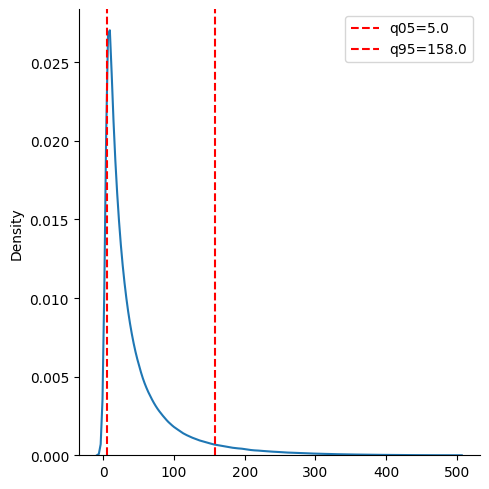

In [50]:
ax = sns.displot(df_session_stats["len"], kind="kde")
q1 = df_session_stats["len"].quantile(0.05)
q2 = df_session_stats["len"].quantile(0.95)
plt.axvline(x=q1, color="red", linestyle='--', label=f"q05={q1}")
plt.axvline(x=q2, color="red", linestyle='--', label=f"q95={q2}")
# l1 = ax.lines[0]

# x1 = l1.get_xydata()[:, 0]
# y1 = l1.get_xydata()[:, 1]

# ax.fill_between(x1, y1, color="red", alpha=0.3)
# ax.margins(x=0, y=0)

plt.legend()
plt.show()

In [51]:
val_df_train

session,aid,ts,type
i64,i64,i64,i64
0,1517085,1659304800025,0
0,1563459,1659304904511,0
0,1309446,1659367439426,0
0,16246,1659367719997,0
0,1781822,1659367871344,0
0,1152674,1659367885796,0
0,1649869,1659369893840,1
0,461689,1659369898050,1
0,305831,1659370027105,2


In [53]:
df_session_stats, df_aid_stats = data_stats(val_df_train)

In [68]:
def warm_users_and_models(pldf_user_stats, pldf_model_stats):
#     min_actions = self.dataset_params["min_actions"]
#     min_users = self.dataset_params["min_users"]
#     min_transactions = self.dataset_params["min_transactions"]
    
    min_actions = 5
    min_users = 5
    min_transactions = 1

    pldf_train_users = (
        pldf_user_stats
        .filter(pl.col("uniq_aids") >= min_actions)
        .filter(
#             (pl.col("uniq_carts") >= min_transactions) |
            (pl.col("uniq_orders") >= min_transactions)
        )
        .select(["session"])
    )

    pldf_train_models = (
        pldf_model_stats
        .filter(pl.col("uniq_sessions") >= min_users)
#         .filter(
# #             (pl.col("uniq_carts") >= min_transactions) |
#             (pl.col("uniq_orders") >= min_transactions)
#         )
        .select(["aid"])
    )

    return pldf_train_users, pldf_train_models

In [69]:
df_train_sessions, df_train_aids = warm_users_and_models(
    df_session_stats, df_aid_stats
)

In [59]:
df_session_stats_valid, df_aid_stats_valid = data_stats(val_df_valid_input)

In [70]:
print("Num lost items for test sessions")

(
    df_aid_stats_valid["aid"].n_unique(),
    (
        df_train_aids.select(["aid"])
        .join(df_aid_stats_valid.select(["aid"]), on="aid", how="inner")
    ).shape,
)

Num lost items for test sessions


(802015, (713420, 1))

In [71]:
df_session_stats.join(df_train_sessions, on="session")

session,uniq_aids,min_ts,max_ts,uniq_clicks,uniq_carts,uniq_orders
i64,u32,"datetime[ms, Etc/GMT-2]","datetime[ms, Etc/GMT-2]",u32,u32,u32
97015,386,2022-08-01 05:54:54.216 +02,2022-08-19 14:35:09.115 +02,386,5,4
1459773,386,2022-08-02 11:14:38.354 +02,2022-08-18 20:59:32.814 +02,385,3,1
5275857,360,2022-08-07 21:21:56.254 +02,2022-08-21 18:46:21.277 +02,358,14,2
8433998,348,2022-08-14 17:35:57.340 +02,2022-08-20 23:24:50.732 +02,348,18,8
115606,347,2022-08-01 06:45:05.836 +02,2022-08-08 17:31:02.591 +02,346,19,1
554746,337,2022-08-01 14:21:26.254 +02,2022-08-20 12:24:56.985 +02,337,25,5
549408,336,2022-08-01 14:16:37.225 +02,2022-08-21 14:24:54.051 +02,336,9,1
720185,340,2022-08-01 16:52:28.371 +02,2022-08-16 12:41:07.378 +02,335,35,15
2142840,342,2022-08-02 23:24:24.317 +02,2022-08-07 22:05:16.922 +02,333,41,1


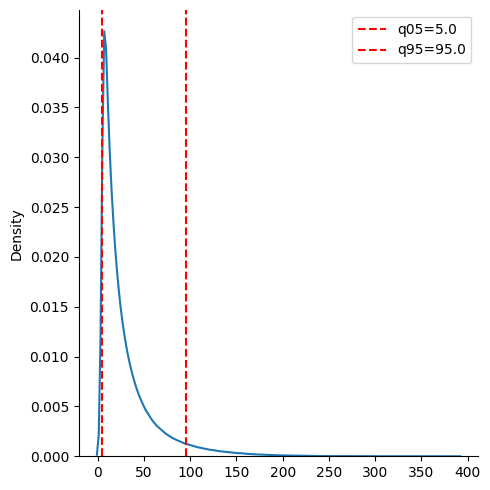

In [67]:
ax = sns.displot(df_session_stats.join(df_train_sessions, on="session")["uniq_aids"], kind="kde")
q1 = df_session_stats.join(df_train_sessions, on="session")["uniq_aids"].quantile(0.05)
q2 = df_session_stats.join(df_train_sessions, on="session")["uniq_aids"].quantile(0.95)
plt.axvline(x=q1, color="red", linestyle='--', label=f"q05={q1}")
plt.axvline(x=q2, color="red", linestyle='--', label=f"q95={q2}")
# l1 = ax.lines[0]

# x1 = l1.get_xydata()[:, 0]
# y1 = l1.get_xydata()[:, 1]

# ax.fill_between(x1, y1, color="red", alpha=0.3)
# ax.margins(x=0, y=0)

plt.legend()
plt.show()

In [74]:
N_LAST_ACTIONS = 100

df_train_interactions_warm = (
    val_df_train
    .join(df_train_sessions, on="session", how="inner")
    .join(df_train_aids, on="aid", how="inner")
    .sort("ts")
    .with_columns([pl.lit(1).alias("ones"),])
    .with_columns([pl.col("ones").cumsum().over("session").alias("user_interaction_rank"),])
    .with_columns([pl.max("user_interaction_rank").over("session").alias("user_interaction_total"),])
    .with_columns([
        (
            pl.col("user_interaction_total") - N_LAST_ACTIONS
        ).alias("split_user_interaction_rank"),
    ])
)

In [75]:
df_train_interactions_warm

session,aid,ts,type,ones,user_interaction_rank,user_interaction_total,split_user_interaction_rank
i64,i64,i64,i64,i32,i32,i32,i32
0,1517085,1659304800025,0,1,1,147,47
3,1425967,1659304800095,1,1,1,226,126
11,1110510,1659304800172,0,1,1,90,-10
13,1674493,1659304800201,0,1,1,78,-22
14,414349,1659304800234,0,1,1,379,279
16,1143723,1659304800274,1,1,1,12,-88
19,1248752,1659304800333,0,1,1,103,3
23,1468783,1659304800378,0,1,1,80,-20
26,818697,1659304800411,0,1,1,43,-57


In [77]:
session_encoder = EntityEncoder(ext_name="session", int_name="uiid")
aid_encoder = EntityEncoder(ext_name="aid", int_name="miid")

In [78]:
session_encoder.set_external_ids(df_train_interactions_warm["session"])
aid_encoder.set_external_ids(df_train_interactions_warm["aid"])

In [79]:
df_train_interactions_warm = (
    df_train_interactions_warm
    .join(session_encoder.mapping_df, on="session", how="left")  # all users
    .join(aid_encoder.mapping_df, on="aid", how="inner")  # only known models
)

In [82]:
splitter = Splitter()

In [92]:
n_valid_users = 40000

df_train_interactions, df_valid_interactions = splitter.user_split(
    df_train_interactions_warm,
    user_col="session",
    test_size=n_valid_users
)

In [93]:
df_valid_interactions, valid_target = splitter.item_leave_one_last_split(
    df_valid_interactions, user_col="session", ts_col="ts"
)

In [11]:
def build_input_sequences(pldf_interactions):
    return (
        pldf_interactions
        .sort("ts")
        .groupby(["session", "uiid"])
        .agg([
            pl.list("miid").alias("miid_seq"),
            pl.list("ts").alias("ts_seq"),
            pl.list("type").alias("transaction_seq"),
#             pl.list("transaction_weight").alias("transaction_seq"),
        ])
    )

def build_target(
        df: pl.DataFrame, user_col: str, item_col: str, ts_col: str, filter: bool = True
    ) -> pl.DataFrame:
    if filter:
        df = df.filter(pl.col("is_transaction") == 1)
        
    return (
        df
        .sort(ts_col)
        .groupby(user_col)
        .agg([
            pl.list(item_col),
            pl.list(ts_col),
            # pl.list(weight_col),
        ])
    )

In [96]:
df_train_seq = build_input_sequences(df_train_interactions)
df_valid_seq = build_input_sequences(df_valid_interactions)

valid_target = build_target(
    valid_target, user_col=["session", "uiid"], item_col="miid", ts_col="ts",
    filter=None
)

In [90]:
df_train_interactions.filter(pl.col("uiid") == 5)

session,aid,ts,type,ones,user_interaction_rank,user_interaction_total,split_user_interaction_rank,uiid,miid
i64,i64,i64,i64,i32,i32,i32,i32,i64,i64
16,1143723,1659304800274,1,1,1,12,-88,5,837977
16,1003508,1659305029468,0,1,2,12,-88,5,735170
16,1031864,1659305048043,0,1,3,12,-88,5,755955
16,756548,1659305105366,0,1,4,12,-88,5,554129
16,756548,1659305128622,1,1,5,12,-88,5,554129
16,1393473,1659305269894,0,1,6,12,-88,5,1021073
16,1393473,1659305273245,1,1,7,12,-88,5,1021073
16,1393473,1659305313337,2,1,8,12,-88,5,1021073
16,1143723,1659305313337,2,1,9,12,-88,5,837977


In [98]:
df_train_seq.filter(pl.col("uiid") == 5)

session,uiid,miid_seq,ts_seq,transaction_seq
i64,i64,list[i64],list[i64],list[i64]
16,5,"[837977, 735170, ... 1152577]","[1659304800274, 1659305029468, ... 1659379224596]","[1, 0, ... 0]"


In [6]:
DATASET_PATH = DATA_FOLDER / "dataset_orders"
DATASET_PATH.mkdir(parents=True, exist_ok=True)

In [99]:
with open(DATASET_PATH / "session_encoder.dill", "wb") as f:
    dill.dump(session_encoder, f)

with open(DATASET_PATH / "aid_encoder.dill", "wb") as f:
    dill.dump(aid_encoder, f)
    
df_train_seq.write_parquet(DATASET_PATH / "input_train.parquet", use_pyarrow=True)
df_valid_seq.write_parquet(DATASET_PATH / "input_valid.parquet", use_pyarrow=True)
valid_target.write_parquet(DATASET_PATH / "valid_target.parquet", use_pyarrow=True)

In [100]:
df_train_seq

session,uiid,miid_seq,ts_seq,transaction_seq
i64,i64,list[i64],list[i64],list[i64]
10654475,996763,"[836401, 674496, ... 245864]","[1661013906685, 1661013955726, ... 1661019410178]","[0, 1, ... 2]"
7721426,829326,"[941055, 1219166, ... 1317136]","[1660385946676, 1660386039254, ... 1661091825095]","[0, 0, ... 0]"
10539050,990763,"[932505, 918370, ... 18475]","[1660992881594, 1660993074718, ... 1661027894559]","[0, 0, ... 0]"
10545018,991114,"[248299, 124088, ... 249380]","[1660993971550, 1660993983125, ... 1660996949019]","[0, 0, ... 2]"
8511454,877716,"[119829, 119829, ... 324719]","[1660499310862, 1660505966389, ... 1660805652018]","[0, 0, ... 2]"
2441195,377328,"[1057705, 572602, ... 1162332]","[1659524138597, 1659590498321, ... 1661011428485]","[0, 0, ... 2]"
4537472,584531,"[1293374, 795660, ... 136926]","[1659791545271, 1659791704451, ... 1659793464120]","[0, 0, ... 2]"
3000129,436637,"[813019, 831334, ... 1293246]","[1659563380218, 1659695165549, ... 1660677485528]","[0, 0, ... 0]"
3908158,525916,"[490653, 1225357, ... 1173771]","[1659695823127, 1659696011431, ... 1661008971714]","[0, 0, ... 0]"


# Build input for target and calc metrics

In [7]:
with open(DATASET_PATH / "session_encoder.dill", "rb") as f:
    session_encoder = dill.load(f)

with open(DATASET_PATH / "aid_encoder.dill", "rb") as f:
    aid_encoder = dill.load(f)

In [ ]:
            pldf_test_seq = (
                pldf_test_users
                .join(pldf_test_seq, on="user_id", how="left")
            )
            # print(pldf_test_seq)

            empty_seqs = [[] for _ in range(pldf_test_seq.shape[0])]
            pldf_test_seq = (
                pldf_test_seq
                .with_columns([
                    # pl.col("uiid").fill_null(pl.lit(user_encoder.size())),
                    pl.col("miid_seq").fill_null(pl.Series("", empty_seqs, dtype=pl.List(pl.Int64))),
                    # pl.col("ts_seq").fill_null(pl.Series("", empty_seqs)),  # FIX IT!!!
                    pl.col("transaction_seq").fill_null(pl.Series("", empty_seqs, dtype=pl.List(pl.Int64))),
                ])
            )

In [96]:
val_df_valid_users = val_df_valid_input.select(["session"]).unique()

In [8]:
val_df_valid_input_interactions = (
    val_df_valid_input
    .join(session_encoder.mapping_df, on="session", how="left")  # all users
    .join(aid_encoder.mapping_df, on="aid", how="inner")  # only known models
)

In [13]:
val_df_valid_seq = build_input_sequences(val_df_valid_input_interactions)

In [99]:
val_df_valid_seq

session,uiid,miid_seq,ts_seq,transaction_seq
i64,i64,list[i64],list[i64],list[i64]
11299566,null,"[979423, 979423, 1107690]","[1661189224551, 1661189284130, 1661189345600]","[0, 0, 0]"
11837644,null,[1283945],[1661359425844],[0]
11651821,null,[356254],[1661287160116],[0]
12014391,null,"[1348163, 1348163, 1315042]","[1661428937885, 1661510508909, 1661510521312]","[0, 0, 0]"
11551152,null,"[1346465, 1346465, ... 1255764]","[1661267980122, 1661268077015, ... 1661268243571]","[0, 1, ... 0]"
12341572,null,"[948789, 191007, 191007]","[1661539574171, 1661539636891, 1661539653344]","[0, 0, 1]"
12762079,null,"[257957, 893305]","[1661694266660, 1661695072148]","[0, 0]"
12714521,null,[664102],[1661684774230],[0]
12579066,null,"[943971, 863879, ... 1141448]","[1661626410441, 1661626430713, ... 1661628009257]","[0, 1, ... 0]"


In [101]:
val_df_valid_seq = (
    val_df_valid_users
    .join(val_df_valid_seq, on="session", how="left")
)

In [103]:
empty_seqs = [[] for _ in range(val_df_valid_seq.shape[0])]
val_df_valid_seq = (
    val_df_valid_seq
    .with_columns([
        # pl.col("uiid").fill_null(pl.lit(user_encoder.size())),
        pl.col("miid_seq").fill_null(pl.Series("", empty_seqs, dtype=pl.List(pl.Int64))),
        # pl.col("ts_seq").fill_null(pl.Series("", empty_seqs)),  # FIX IT!!!
        pl.col("transaction_seq").fill_null(pl.Series("", empty_seqs, dtype=pl.List(pl.Int64))),
    ])
)

In [104]:
val_df_valid_seq

session,uiid,miid_seq,ts_seq,transaction_seq
i64,i64,list[i64],list[i64],list[i64]
11107743,null,"[910992, 535430, 910992]","[1661126400192, 1661126418250, 1661391126514]","[0, 0, 0]"
11107744,null,"[161133, 1140689, ... 1140689]","[1661126401190, 1661126439064, ... 1661126463911]","[0, 1, ... 0]"
11107745,null,"[564424, 1232508, ... 490700]","[1661126402749, 1661126476951, ... 1661126813401]","[0, 0, ... 0]"
11107746,null,"[831286, 582447]","[1661126404790, 1661126527755]","[0, 0]"
11107747,null,"[737136, 737136, ... 452498]","[1661126408858, 1661126509993, ... 1661464719813]","[0, 0, ... 0]"
11107748,null,[845545],[1661126410139],[0]
11107749,null,"[112481, 466066]","[1661126410217, 1661188513088]","[0, 0]"
11107750,null,"[27921, 533781]","[1661126412752, 1661384220709]","[0, 0]"
11107754,null,[1054071],[1661126423457],[0]


In [107]:
!ls -lah $DATASET_PATH

total 385M
drwxr-xr-x 2 sirpantene sirpantene  172 Jan 17 20:25 .
drwxrwxr-x 9 sirpantene sirpantene 4.0K Jan 17 10:26 ..
-rw-r--r-- 1 sirpantene sirpantene  11M Jan 17 10:23 aid_encoder.dill
-rw-r--r-- 1 sirpantene sirpantene 305M Jan 17 10:23 input_train.parquet
-rw-r--r-- 1 sirpantene sirpantene  13M Jan 17 10:23 input_valid.parquet
-rw-r--r-- 1 sirpantene sirpantene 7.8M Jan 17 10:23 session_encoder.dill
-rw-r--r-- 1 sirpantene sirpantene  48M Jan 17 20:25 val_df_valid_seq.parquet
-rw-r--r-- 1 sirpantene sirpantene 853K Jan 17 10:23 valid_target.parquet


## Make recs

In [55]:
from tasks.data.torch_datasets.bert4rec import BERT4RecDataset, BERT4RecTransactionsDataset
from tasks.data.dataset.mappers import EntityEncoder
from tasks.models.bert4rec import BERT4Rec, BERT4RecTransactions
from tasks.models.pytorch_lightning.bert4rec import LitBERT4Rec, LitBERT4RecTransactions

from tasks.evaluation import METRICS
from tasks.utils import get_module_class, load_config_with_creds, Connection, load_pickle

In [56]:
def get_torch_model_cfg(cfg, user_encoder, model_encoder):
    n_users = user_encoder.size
    n_items = model_encoder.size
    pad_token = n_items
    mask_token = n_items + 1
    # update num item
    n_items_emb = n_items + 2
    
    model_config = {
        "n_users": n_users,
        "n_items": n_items,
        "n_items_emb": n_items_emb,
        "pad_token": pad_token,
        "mask_token": mask_token,
        
#         "mask_proba": cfg["mask_token_proba"], 
#         "max_seq_len": cfg["n_last_actions"],
    }
    
    model_config.update(**cfg)
    return model_config

In [57]:
cfg = load_config_with_creds(confpath="../../configs/otto.yaml", **{"n_train_days": 30})

In [58]:
DATASET_PATH = DATA_FOLDER / "dataset_orders"
DATASET_PATH.mkdir(parents=True, exist_ok=True)

In [59]:
with open(DATASET_PATH / "session_encoder.dill", "rb") as f:
    session_encoder = dill.load(f)

with open(DATASET_PATH / "aid_encoder.dill", "rb") as f:
    aid_encoder = dill.load(f)
    
val_df_valid_seq = pl.read_parquet(DATASET_PATH / "val_df_valid_seq.parquet")

In [60]:
torch_model_cfg = get_torch_model_cfg(cfg["model_params"], session_encoder, aid_encoder)

In [61]:
!ls -lah /data/services/tensorboard/

total 8.0K
drwxr-xr-x  5 1006 1006  143 Jan 27 15:16  .
drwxr-xr-x  5 1006 1006   55 Dec 16 10:05  ..
drwxrwxr-x 10 1006 1006  142 Jan 27 14:47 'exp=mylp_prod;dataset=bert4rec_transactions;model=BERT4RecTransactions'
drwxr-xr-x 26 1006 1006 4.0K Jan 24 23:54  otto
drwxr-xr-x 23 1006 1006 4.0K Jan 17 20:27  vanilla_bert4rec_watch_time_payers_only


In [62]:
import os

CKPT_FOLDER = Path(
#     "/home/sirpantene/data/"
    "/data/"
    "services/tensorboard/vanilla_bert4rec_watch_time_payers_only/version_21/checkpoints/"
)

os.listdir(CKPT_FOLDER)

['epoch=49-step=254750.ckpt']

In [63]:
checkpoint = CKPT_FOLDER / os.listdir(CKPT_FOLDER)[0]
checkpoint

PosixPath('/data/services/tensorboard/vanilla_bert4rec_watch_time_payers_only/version_21/checkpoints/epoch=49-step=254750.ckpt')

In [67]:
torch_model_cfg["n_last_actions"] = 200
bert4rec = BERT4RecTransactions(model_config=torch_model_cfg)
loss = bert4rec.ce_loss()

In [68]:
ks = [4, 12, 60]
metric_names = ["hit", "precision", "recall"]

test_metrics = [
    METRICS.get(m)(k)
    for m in metric_names
    for k in ks
]

topk = max(ks)
valid_metric = METRICS.get("hit")(topk)


model = LitBERT4RecTransactions.load_from_checkpoint(
    checkpoint, 
    model=bert4rec,
    loss=loss,
    valid_metric=valid_metric,
    df_valid_actual=None,
    test_metrics=test_metrics,
    df_test_actual=None,
    user_encoder=session_encoder,
    model_encoder=aid_encoder,
    topk=topk
)
model.eval()

LitBERT4RecTransactions(
  (model): BERT4RecTransactions(
    (bert_embedding): BERTEmbedding(
      (token): TokenEmbedding(1359712, 32, padding_idx=1359710)
      (position): PositionEmbedding(
        (pos_emb): Embedding(200, 32)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=66, out_features=66, bias=True)
      )
      (linear1): Linear(in_features=66, out_features=264, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=264, out_features=66, bias=True)
      (norm1): LayerNorm((66,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((66,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder_blocks): TransformerEncoder(
      (layers): ModuleList(
     

In [69]:
def _get_recommended_list(user_ids, uiids, scores, users_history, candidates=None, topk=20):
    # scores = scores[:, -1, :]  # B x V
    # print("scores: ", scores.shape)
    # raise Exception

    # sort scores
#     zero_t = torch.FloatTensor([0.]).to("cuda")  # bad
#     one_t = torch.FloatTensor([1.]).to("cuda")  # bad

    # zero items from user history
#     scores_clean = torch.where(users_history == zero_t, scores, zero_t)
    # zero items not in candidates
#     if candidates is not None:
#         scores_clean = torch.where(candidates == one_t, scores_clean, zero_t)
    scores_clean = scores
    scores_sorted, indices = torch.sort(scores_clean, dim=1, descending=True)

    # print(user_ids, type(user_ids))
    user_ids = user_ids.tolist()
    uiids = uiids.squeeze(1).tolist()
    indices_topk = indices[:, :topk].detach().cpu().numpy().tolist()
    scores_topk = scores_sorted[:, :topk].detach().cpu().numpy().tolist()

    return {"user_id": user_ids, "uiid": uiids, "miid": indices_topk, "scores": scores_topk}


In [70]:
test_dataset = BERT4RecTransactionsDataset(
    df_history_seqs=val_df_valid_seq, dataset_config=torch_model_cfg
)
test_dataloader = DataLoader(
    test_dataset, batch_size=cfg.train_params.batch_size,
    num_workers=1,
)

In [71]:
cfg.train_params

{'batch_size': 128, 'n_gpus': 3, 'max_epochs': 200}

In [72]:
torch_model_cfg

{'n_users': 1018057,
 'n_items': 1359710,
 'n_items_emb': 1359712,
 'pad_token': 1359710,
 'mask_token': 1359711,
 'dataset_classname': 'BERT4RecTransactionsDataset',
 'model_classname': 'BERT4RecTransactions',
 'lit_model_classname': 'OttoLitBERT4RecTransactions',
 'n_last_actions': 200,
 'mask_token_proba': 0.2,
 'emb_size': 32,
 'n_attn_heads': 2,
 'n_trm_blocks': 2}

In [73]:
# valid on sample
n_sample_batches = 100
gpu = True
b_recs = []
i = 0
if gpu:
    model.model.to(0)

for batch in tqdm(test_dataloader):
    if gpu:
        batch = [_.to(0) for _ in batch]
    user_ids, uiids, masked_seqs, transactions, labels, test_seqs, test_transactions, seqs, users_history = batch
    logits = model.model.recommend(uiids, test_seqs, test_transactions, labels=None)
    batch_recs = _get_recommended_list(user_ids, uiids, logits, users_history, topk=200)
    b_recs.append(batch_recs)
    i += 1
    if i > n_sample_batches:
        break

  0%|          | 0/10183 [00:00<?, ?it/s]

In [95]:
logits.shape

torch.Size([128, 1359712])

In [117]:
idx = 0
print(test_seqs[idx])
print(logits[idx].sum(), logits[idx].max(), logits[idx].min(), logits[idx].argmax())

tensor([1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710, 1359710,
        1359710, 1359710, 1359710, 13597

In [120]:
b_recs[100]["miid"]

[[1250464,
  688481,
  853091,
  1134823,
  951001,
  1339119,
  702574,
  425018,
  197129,
  1179485,
  498833,
  398444,
  309464,
  759296,
  475976,
  1081254,
  337413,
  1025593,
  181328,
  1278,
  1349293,
  711508,
  429962,
  702155,
  1306423,
  1344937,
  473290,
  504716,
  591293,
  99615,
  1299962,
  1091903,
  1352673,
  932527,
  482669,
  915835,
  21830,
  529898,
  1144140,
  425282,
  408253,
  435839,
  121570,
  326360,
  3872,
  1284188,
  789273,
  463747,
  1049618,
  668825,
  1065210,
  198428,
  915339,
  402382,
  239509,
  1001577,
  414459,
  25113,
  1226848,
  1099547,
  365211,
  897499,
  937101,
  401669,
  14210,
  553095,
  13014,
  1263046,
  1149616,
  134209,
  947091,
  323497,
  875354,
  23204,
  807356,
  457112,
  267693,
  998639,
  1344745,
  459439,
  330905,
  771172,
  484242,
  934410,
  570210,
  1146640,
  1019080,
  180329,
  746715,
  1239951,
  819228,
  705700,
  382690,
  632500,
  810844,
  336718,
  1121586,
  676013,
  72

In [92]:
# check sample

recs = {"session": [], "uiid": [], "miid": [], "scores": []}

for b_rec in b_recs:
    recs["session"].extend(b_rec["user_id"])
    recs["uiid"].extend(b_rec["uiid"])
    recs["miid"].extend(b_rec["miid"])
    recs["scores"].extend(b_rec["scores"])

print("reverse model mapping...")
recs["aid"] = [
    aid_encoder.external_ids[rec_miids].tolist()
    for rec_miids in recs["miid"]
]  
df_recs = pl.DataFrame(recs)


# make submission
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 200


for row in tqdm(df_recs.rows()):
    test_session = row[0]
    session_types = [f"{test_session}_{t}" for t in types]
    rec_items = row[4][:topk]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * 3

    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

df_submission = pl.DataFrame(submission_dict)

reverse model mapping...


  0%|          | 0/12928 [00:00<?, ?it/s]

In [93]:
# 49 epoch - transaction = 1, model.eval()
valid_stats = calc_valid_score(df_submission, topk=topk)

validation score: 0.39273092496110823
recall per type: type
carts    0.3622
clicks   0.5149
orders   0.3876
dtype: float64


In [91]:
df_recs

session,uiid,miid,scores,aid
i64,i64,list[i64],list[f64],list[i64]
11107743,1359711,"[910992, 164266, ... 24844]","[7.502857, 6.385752, ... 0.751974]","[1243310, 224347, ... 33775]"
11107744,1359711,"[1140689, 608298, ... 131363]","[-22.038578, -24.70615, ... -32.350502]","[1556644, 830498, ... 179440]"
11107745,1359711,"[490700, 1232508, ... 670135]","[11.849604, 8.768887, ... 2.314719]","[670066, 1682122, ... 914896]"
11107746,1359711,"[582447, 608784, ... 816907]","[7.368326, 4.63255, ... -0.936006]","[795232, 831165, ... 1114959]"
11107747,1359711,"[452498, 1002994, ... 728558]","[6.59384, 4.198973, ... -3.170907]","[618078, 1368814, ... 994478]"
11107748,1359711,"[845545, 13115, ... 1171815]","[-4.847091, -5.626913, ... -11.020895]","[1154005, 17868, ... 1599125]"
11107749,1359711,"[466066, 456075, ... 1241581]","[-10.656031, -13.260389, ... -19.995535]","[636540, 622864, ... 1694532]"
11107750,1359711,"[533781, 587637, ... 905592]","[11.176851, 7.98128, ... 2.3104]","[728766, 802264, ... 1235986]"
11107754,1359711,"[1054071, 937100, ... 265078]","[-16.815014, -18.366386, ... -23.97455]","[1438446, 1278941, ... 362466]"


In [90]:
val_df_valid_targets.filter(pl.col("type") == "orders")

session,type,ground_truth
i64,str,list[i64]
11107757,"""orders""",[69701]
11107761,"""orders""","[217117, 559821, ... 1566659]"
11107767,"""orders""",[521316]
11107788,"""orders""","[53600, 220847, ... 1659575]"
11107795,"""orders""","[125419, 947971]"
11107800,"""orders""",[351940]
11107808,"""orders""","[1312865, 1588025]"
11107865,"""orders""",[267965]
11107869,"""orders""",[406817]


In [128]:
# 49 epoch - transaction = 1, model.eval()
valid_stats = calc_valid_score(df_submission)

validation score: 0.27724628964533576
recall per type: type
carts    0.2539
clicks   0.3494
orders   0.2769
dtype: float64


In [163]:
# 47 epoch - transaction = 1
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  )


validation score: 0.26125756035583647
recall per type: type
carts    0.2326
clicks   0.3051
orders   0.2683
dtype: float64


In [153]:
# 37 epoch - transaction = 1
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx]


validation score: 0.2598407297572678
recall per type: type
carts    0.2296
clicks   0.2932
orders   0.2694
dtype: float64


In [144]:
# 33 epoch - transaction = 2
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.27417433541498976
recall per type: type
carts    0.2076
clicks   0.2747
orders   0.3074
dtype: float64


In [136]:
# 32 epoch - transaction = 2
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.27394793845484244
recall per type: type
carts    0.2097
clicks   0.2804
orders   0.3050
dtype: float64


In [128]:
# 31 epoch - transaction = 2
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.27053889232443257
recall per type: type
carts    0.2025
clicks   0.2721
orders   0.3043
dtype: float64


In [120]:
# 30 epoch - transaction = 2
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.2673192806340996
recall per type: type
carts    0.1954
clicks   0.2662
orders   0.3035
dtype: float64


In [155]:
0.6 * 0.3078 + 0.3 * 0.2296 + 0.1 * 0.2932

0.28288

In [111]:
# 29 epoch - transaction = 2
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.2721228007191558
recall per type: type
carts    0.2012
clicks   0.2710
orders   0.3078
dtype: float64


In [106]:
# 29 epoch - transaction = 0
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.25452531837823394
recall per type: type
carts    0.2159
clicks   0.2917
orders   0.2676
dtype: float64


In [100]:
# 29 epoch
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.2533626344686817
recall per type: type
carts    0.2253
clicks   0.2870
orders   0.2618
dtype: float64


In [92]:
# 28 epoch
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.2504408598517414
recall per type: type
carts    0.2209
clicks   0.2842
orders   0.2596
dtype: float64


In [82]:
# 16 epoch
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.23525784928325094
recall per type: type
carts    0.2065
clicks   0.2569
orders   0.2460
dtype: float64


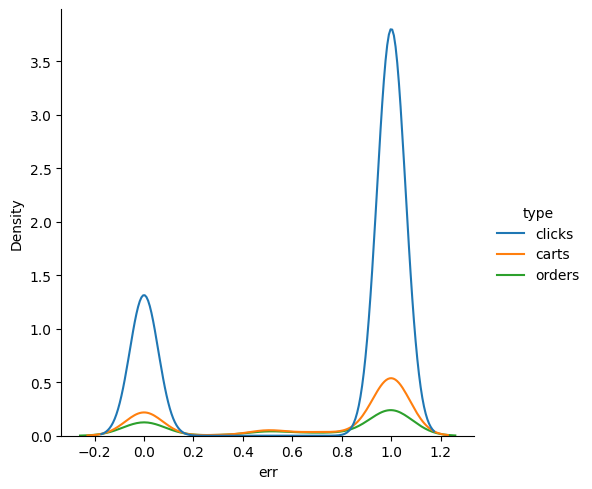

In [83]:
valid_stats["err"] = 1 - (valid_stats["hits"] / valid_stats["gt_count"])
sns.displot(data=valid_stats, x="err", hue="type", kind="kde",
#             bins=100, multiple="stack"
           )

In [59]:
# 15 epoch
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.2305393648019443
recall per type: type
carts    0.2022
clicks   0.2527
orders   0.2410
dtype: float64


In [61]:
valid_stats["err"] = 1 - (valid_stats["hits"] / valid_stats["gt_count"])

In [62]:
valid_stats

,session_type,labels,session,type,ground_truth,hits,gt_count,err
0,11107743_clicks,"[224347, 1283990, 1836775, 631881, 1208872, 12...",11107743,clicks,[224347],1,1,0.0000
1,11107743_carts,"[224347, 1283990, 1836775, 631881, 1208872, 12...",11107743,carts,[],0,0,NaN
2,11107743_orders,"[224347, 1283990, 1836775, 631881, 1208872, 12...",11107743,orders,[],0,0,NaN
3,11107744_clicks,"[1556644, 1561403, 1819062, 325999, 1731078, 3...",11107744,clicks,[1075085],0,1,1.0000
4,11107744_carts,"[1556644, 1561403, 1819062, 325999, 1731078, 3...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4,1.0000
...,...,...,...,...,...,...,...,...
77563,11142125_carts,"[804430, 480424, 1631769, 918548, 1426045, 699...",11142125,carts,[],0,0,NaN
77564,11142125_orders,"[804430, 480424, 1631769, 918548, 1426045, 699...",11142125,orders,[],0,0,NaN
77565,11142126_clicks,"[847217, 327660, 1660752, 1592741, 1720144, 10...",11142126,clicks,[394223],0,1,1.0000
77566,11142126_carts,"[847217, 327660, 1660752, 1592741, 1720144, 10...",11142126,carts,"[1018472, 1020512]",0,2,1.0000


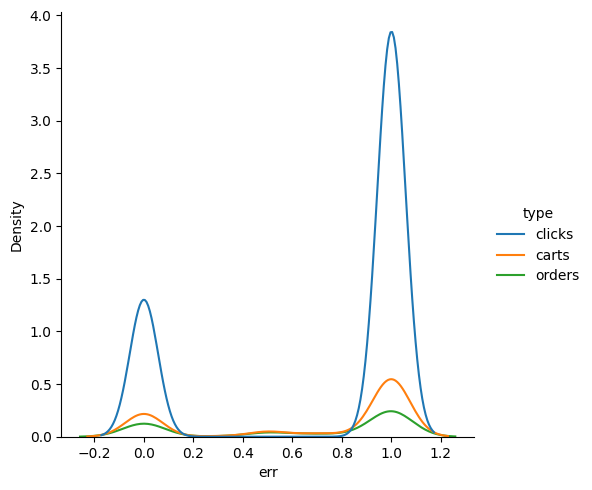

In [72]:
sns.displot(data=valid_stats, x="err", hue="type", kind="kde",
#             bins=100, multiple="stack"
           )

In [50]:
# 14 epoch
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.22796954263987834
recall per type: type
carts    0.1981
clicks   0.2499
orders   0.2392
dtype: float64


In [37]:
# 13 epoch
valid_stats = calc_valid_score(df_submission)

reverse model mapping...


  0%|          | 0/25856 [00:00<?, ?it/s]

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.22298060629066774
recall per type: type
carts    0.1958
clicks   0.2443
orders   0.2330
dtype: float64


In [43]:
df_recs

session,uiid,miid,scores,aid
i64,i64,list[i64],list[f64],list[i64]
11107743,1359711,"[910992, 1346936, ... 1023868]","[13.803345, 13.710431, ... 10.864183]","[1243310, 1838173, ... 1397226]"
11107744,1359711,"[1140689, 608298, ... 603329]","[12.450545, 12.235902, ... 9.875624]","[1556644, 830498, ... 823793]"
11107745,1359711,"[490700, 1232508, ... 1098062]","[16.220692, 13.240041, ... 9.929157]","[670066, 1682122, ... 1498443]"
11107746,1359711,"[582447, 608784, ... 528102]","[16.246214, 14.154697, ... 12.216076]","[795232, 831165, ... 721034]"
11107747,1359711,"[452498, 143367, ... 993330]","[18.415661, 17.665167, ... 13.055287]","[618078, 195833, ... 1355636]"
11107748,1359711,"[924524, 1129206, ... 245702]","[13.308048, 12.419013, ... 9.946695]","[1261763, 1540968, ... 335959]"
11107749,1359711,"[112481, 1065079, ... 302174]","[15.604442, 15.094566, ... 12.398868]","[153565, 1453464, ... 412879]"
11107750,1359711,"[533781, 999155, ... 588856]","[14.853532, 12.395276, ... 10.167165]","[728766, 1363631, ... 803928]"
11107754,1359711,"[896933, 521856, ... 365842]","[12.711782, 12.553848, ... 11.150994]","[1224261, 712456, ... 499919]"


In [ ]:
# add empty sequences 

In [80]:
recs = {"session": [], "uiid": [], "miid": [], "scores": []}

for b_rec in b_recs:
    recs["session"].extend(b_rec["user_id"])
    recs["uiid"].extend(b_rec["uiid"])
    recs["miid"].extend(b_rec["miid"])
    recs["scores"].extend(b_rec["scores"])

print("reverse model mapping...")
recs["aid"] = [
    aid_encoder.external_ids[rec_miids].tolist()
    for rec_miids in recs["miid"]
]  
df_recs = pl.DataFrame(recs)

reverse model mapping...


In [95]:
df_recs.write_parquet("__valid__bert4rec_on_orders_12_epoch_recs.parquet")

In [87]:
# make submission

submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 20


for row in tqdm(df_recs.rows()):
    test_session = row[0]
    session_types = [f"{test_session}_{t}" for t in types]
    rec_items = row[4]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * 3

    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1283553 [00:00<?, ?it/s]

In [88]:
df_submission = pl.DataFrame(submission_dict)

In [91]:
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.23294473236811464
recall per type: type
carts    0.21
clicks   0.25
orders   0.24
dtype: float64


In [92]:
valid_stats

,session_type,labels,session,type,ground_truth,hits,gt_count
0,11299566_clicks,"[1379287, 102896, 1583257, 217858, 1361914, 58...",11299566,clicks,[1762115],0,1
1,11299566_carts,"[1379287, 102896, 1583257, 217858, 1361914, 58...",11299566,carts,[1336527],0,1
2,11299566_orders,"[1379287, 102896, 1583257, 217858, 1361914, 58...",11299566,orders,[],0,0
3,11837644_clicks,"[1752210, 1785442, 288928, 128909, 1773157, 75...",11837644,clicks,[468686],0,1
4,11837644_carts,"[1752210, 1785442, 288928, 128909, 1773157, 75...",11837644,carts,[],0,0
...,...,...,...,...,...,...,...
3850654,12573474_carts,"[1785780, 108856, 487335, 1057481, 1296683, 12...",12573474,carts,[1040233],0,1
3850655,12573474_orders,"[1785780, 108856, 487335, 1057481, 1296683, 12...",12573474,orders,[],0,0
3850656,12852580_clicks,"[1594826, 476527, 1387394, 289723, 126754, 128...",12852580,clicks,[1661663],0,1
3850657,12852580_carts,"[1594826, 476527, 1387394, 289723, 126754, 128...",12852580,carts,[],0,0


In [93]:
valid_stats.query("hits > 0")

,session_type,labels,session,type,ground_truth,hits,gt_count
9,12014391_clicks,"[1193738, 1794751, 969875, 1839863, 258353, 16...",12014391,clicks,[1839863],1,1
25,12579066_carts,"[836818, 447820, 1512911, 1757740, 950661, 162...",12579066,carts,"[1179134, 1557649]",1,2
33,12571298_clicks,"[158853, 120022, 738987, 935830, 1311574, 1494...",12571298,clicks,[1494737],1,1
42,11534972_clicks,"[1125782, 76169, 329907, 1048201, 758874, 1878...",11534972,clicks,[1236968],1,1
48,12824523_clicks,"[520311, 1670116, 169239, 96166, 1283268, 8187...",12824523,clicks,[169239],1,1
...,...,...,...,...,...,...,...
3850602,12153021_clicks,"[1751868, 1260467, 1729380, 974644, 1154070, 7...",12153021,clicks,[1836089],1,1
3850626,11458846_clicks,"[1504389, 49313, 177688, 976046, 406000, 13424...",11458846,clicks,[49313],1,1
3850632,12132606_clicks,"[1549432, 1274224, 277965, 1716070, 37226, 722...",12132606,clicks,[1274224],1,1
3850635,12214321_clicks,"[481753, 274894, 1409559, 10851, 1400426, 1153...",12214321,clicks,[10851],1,1


In [94]:
valid_stats.query("hits > 0")["session"].nunique()

374340

# check all items from session as a predict

check capacity and old items score increasing

In [6]:
df_preds = (
    val_df_valid_input
    .groupby("session")
    .agg([
        pl.col("aid").unique()
    ])
)

In [7]:
# make submission

submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 20


for row in tqdm(df_preds.rows()):
    test_session = row[0]
    session_types = [f"{test_session}_{t}" for t in types]
    rec_items = row[1]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * 3

    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1303355 [00:00<?, ?it/s]

In [8]:
df_submission = pl.DataFrame(submission_dict)

In [9]:
valid_stats = calc_valid_score(df_submission)

/home/sirpantene/tasks/notebooks/otto/otto_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.4557058617601949
recall per type: type
carts    0.29
clicks   0.32
orders   0.56
dtype: float64
